In [1]:
%matplotlib inline

from subprocess import Popen, PIPE, CalledProcessError
import re
import ipywidgets as widgets
import time
import getpass
from encrypt import decryptCredentials,decryptString
import psycopg2 as db
from psycopg2.extensions import AsIs
from psycopg2.extras import execute_values 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
import xarray as xr
from shapely.wkb import loads
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.point import Point
from shapely.ops import cascaded_union

# import plotly.plotly as py
# import plotly.tools as tools
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.shapereader as shpreader

import os.path
from functools import partial

from IPython.display import HTML

# tools.set_credentials_file(username='calidonio', api_key='LqhUF9UtPewuw65GDmzO')

# init_notebook_mode()

## Getting polygon for basin

In [2]:
token = b'gAAAAABayyyn8ZnEstm8ZQqClUYQ-IqFFuMO4QTbmFJADHWBAcirh52s5stDwSwtVK7qVm5tzdTNFxTQjuRF28b1t2rosFSl_nnTowWrD4itOjkzF7s6Kg_qa1Adqpj59OAfBapgkToUQUHvEFY1Njc4he36AC76gmb8t0CJCq4ze2pDHWIlGdDacZxQ1jq14uLVxrFfCTSxDPX8Mx9W1av723etkOdWvw=='
key = getpass.getpass('Password: ')
credentials = decryptCredentials(token,key)

# Testing connection to database
try : 
    conn = db.connect("dbname={} user={} host={} password={}".format(credentials['database'],credentials['username'],credentials['host'],credentials['password']))
    print('Connection successful!')
    conn.close() 
except :
    print("Unable to connect")
    
 

Password: ········
Connection successful!


(4305663.27233919, 4307945.77233919, 4138217.10566967, 4142369.60566967)

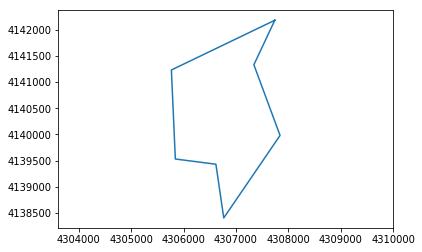

In [3]:
basinSchema = 'francois'
stationName = 'Langtjern'

getBox=True
if getBox:
    conn = db.connect("dbname={} user={} host={} password={}".format(credentials['database'],
                                                                           credentials['username'],
                                                                            credentials['host'],
                                                                            credentials['password']
                                                                          )
                           )
    #And a test query
    cursor = conn.cursor()

    cursor.execute('''SELECT ST_Simplify(a.basin,250) FROM %(tableSHP)s AS a
                      WHERE a.station_name ~ '^%(name)s';'''
                      ,{"tableSHP": AsIs(basinSchema+'.resultsShp'), 'name': AsIs(stationName)}
                  )

    box = cursor.fetchone()
    
    conn.close()

basin = loads(box[0], hex=True)
basin = cascaded_union(basin)
x,y = basin.exterior.xy
plt.plot(x,y)
plt.axis('equal')

# Uploading gridded dataset to database and getting areal average


In [4]:
temperatureFile = '~/Downloads/temperature_{}.nc'
rainFile = '~/Downloads/rain_{}.nc'
maxTempFile = '~/Downloads/max_temp_{}.nc'
minTempFile = '~/Downloads/min_temp_{}.nc'

<xarray.DataArray 'RR' (time: 17348, Y: 8, X: 6)>
[832704 values with dtype=float32]
Coordinates:
  * Y        (Y) float64 4.144e+06 4.142e+06 4.142e+06 ... 4.138e+06 4.136e+06
  * X        (X) float64 4.304e+06 4.306e+06 4.306e+06 ... 4.308e+06 4.31e+06
  * time     (time) datetime64[ns] 1970-12-31T18:00:00 ... 2018-06-29T18:00:00
    lat      (Y, X) float32 ...
    lon      (Y, X) float32 ...
Attributes:
    grid_mapping:      projection_laea
    prod_date:         2018-09-21
    software_release:  v0.1.0-beta
    units:             kg/m^2
    standard_name:     precipitation_amount
    long_name:         daily total precipitation amount
    cell_methods:      time: sum
    _ChunkSizes:       [   1 1010  775]


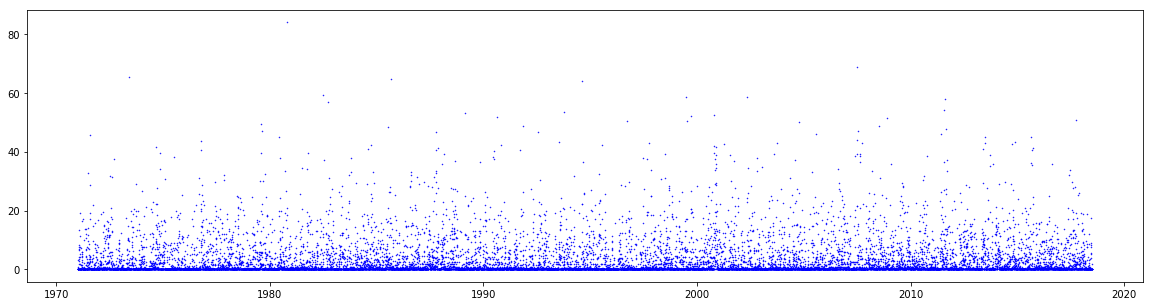

In [5]:
stationName = 'Langtjern'
nc_file=rainFile.format(stationName)
nc_data = xr.open_dataset(nc_file)
rain = nc_data.RR 
dataShape = rain.shape

print(rain)
rain1d = rain.isel(X=0, Y=0)
time=nc_data.time
plt.figure(figsize=(20,5))
plt.plot(time,rain1d,'b.',markersize=1)
nc_data.close()


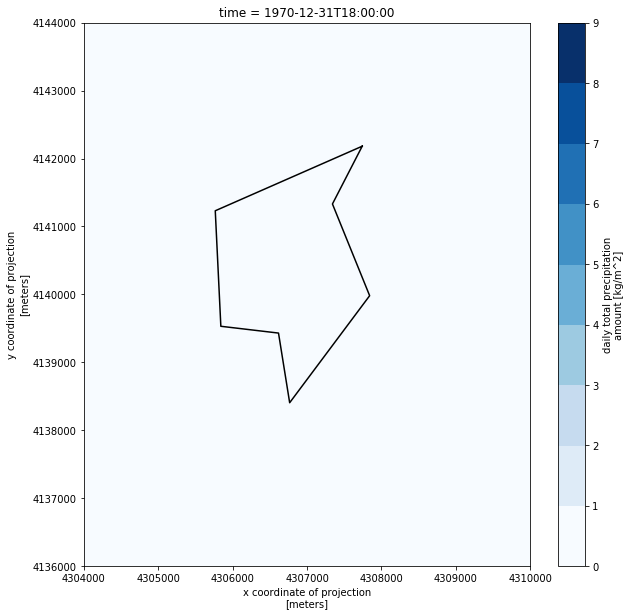

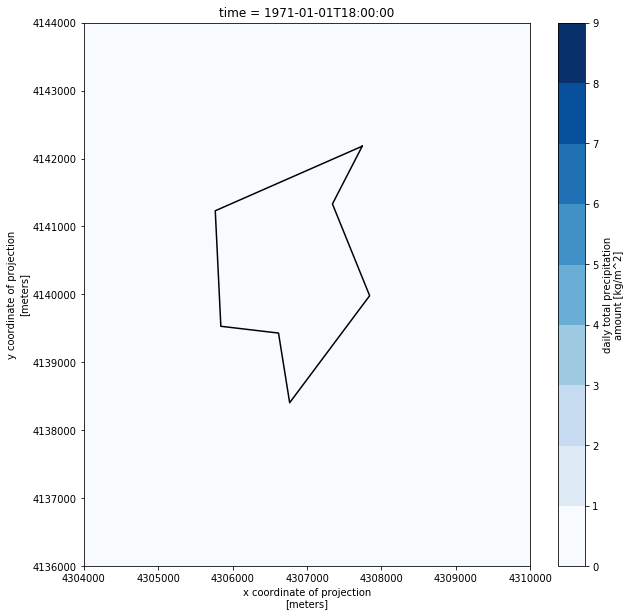

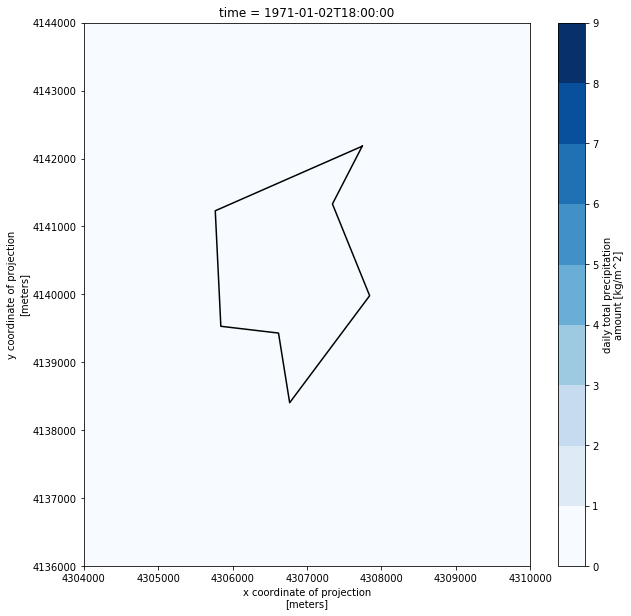

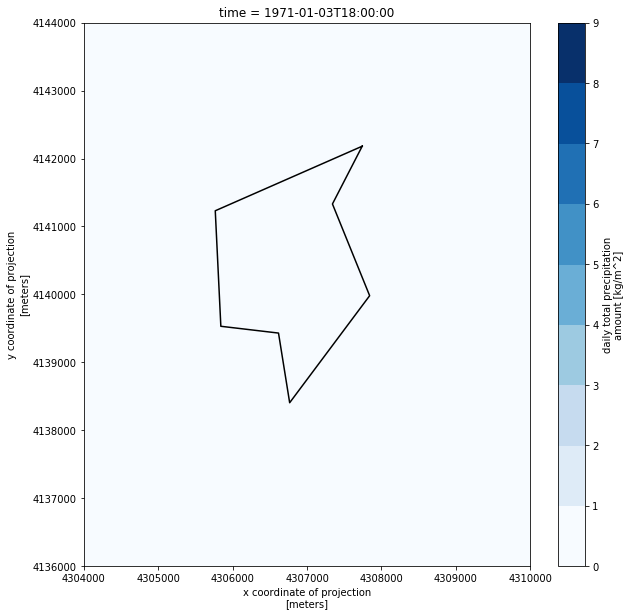

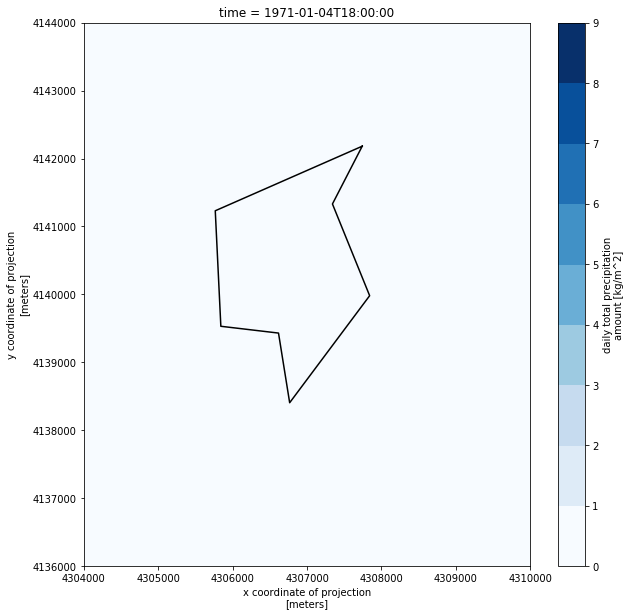

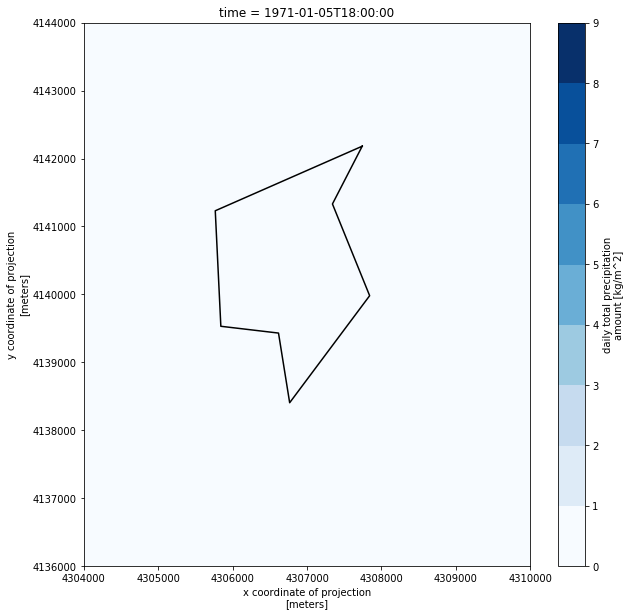

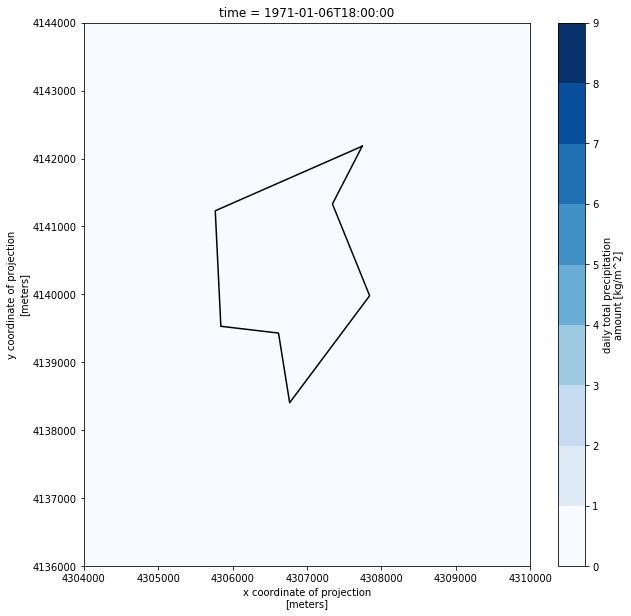

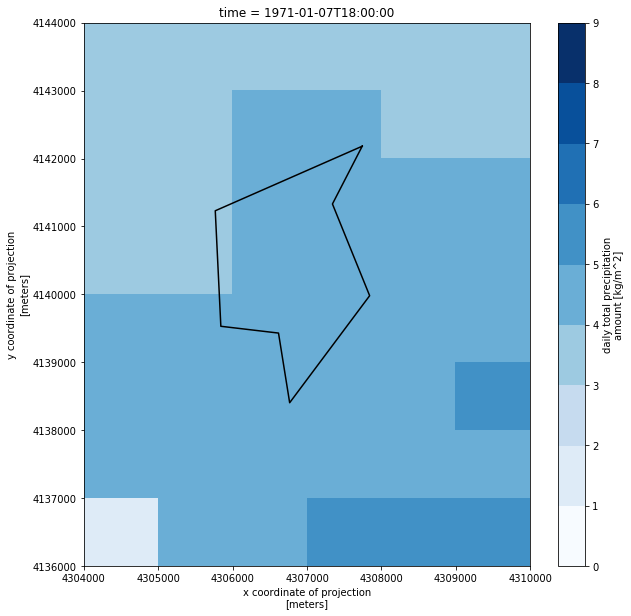

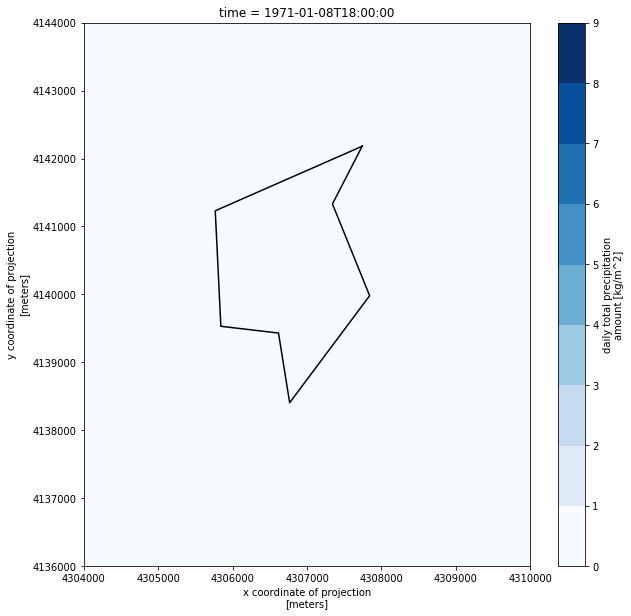

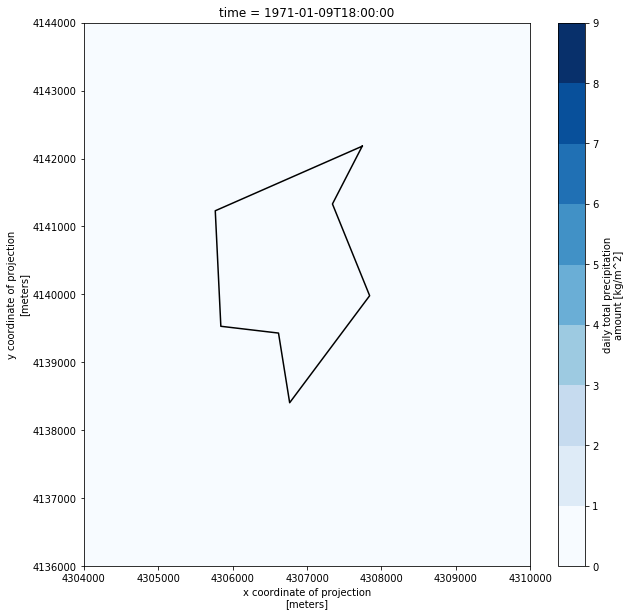

In [6]:
rng = [float(x) for x in range(10)]

for i in range(10):
    rain2d = rain.isel(time=i)
    plt.figure(figsize=(10,10))
    rain2d.plot(levels=rng,cmap=plt.cm.Blues)
    plt.plot(x,y,'k-')
    
del rain   

<xarray.DataArray 'TG' (time: 17348, Y: 8, X: 6)>
array([[[-17.      , -17.100006, ..., -17.299988, -17.5     ],
        [-16.899994, -17.      , ..., -17.299988, -17.299988],
        ...,
        [-16.600006, -16.600006, ..., -16.899994, -17.      ],
        [-16.5     , -16.5     , ..., -16.899994, -17.      ]],

       [[-18.09999 , -18.09999 , ..., -18.299988, -18.5     ],
        [-17.899994, -18.09999 , ..., -18.199997, -18.199997],
        ...,
        [-17.5     , -17.5     , ..., -17.699997, -17.899994],
        [-17.5     , -17.5     , ..., -17.699997, -17.899994]],

       ...,

       [[ 17.5     ,  17.200012, ...,  18.      ,  17.5     ],
        [ 17.300018,  17.      , ...,  17.399994,  18.200012],
        ...,
        [ 16.200012,  16.5     , ...,  16.700012,  17.200012],
        [ 16.200012,  16.600006, ...,  16.300018,  17.      ]],

       [[ 15.700012,  15.399994, ...,  16.      ,  15.600006],
        [ 15.600006,  15.200012, ...,  15.5     ,  16.200012],
        ..

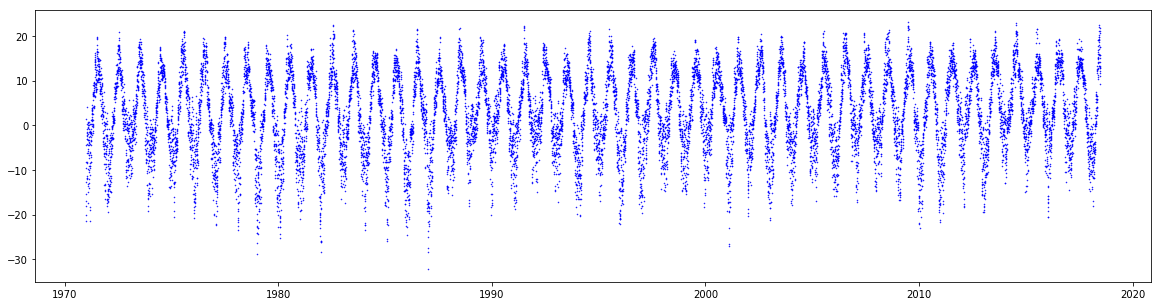

In [7]:
nc_file=temperatureFile.format(stationName)
nc_data = xr.open_dataset(nc_file)
air = nc_data.TG - 273.15
print(air)
time=nc_data.time
air1d = air.isel(X=0, Y=0)
plt.figure(figsize=(20,5))
plt.plot(time,air1d,'b.',markersize=1)

nc_data.close()

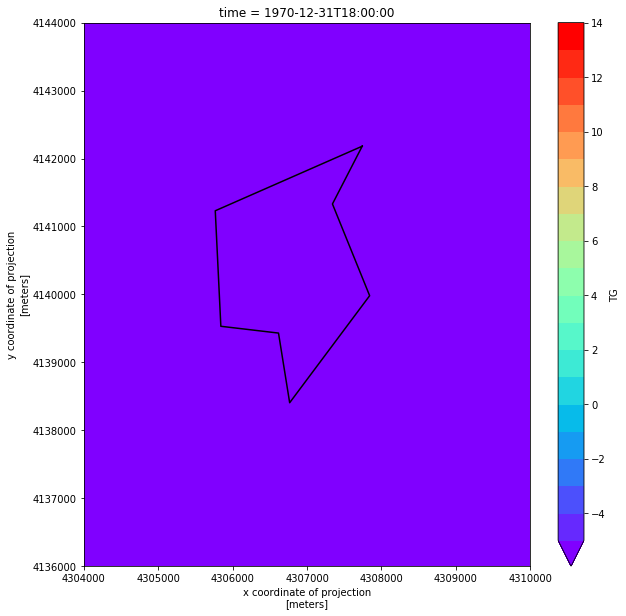

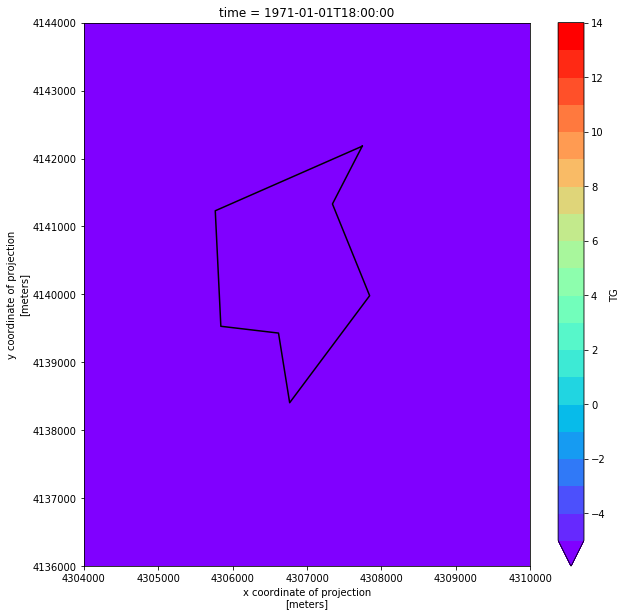

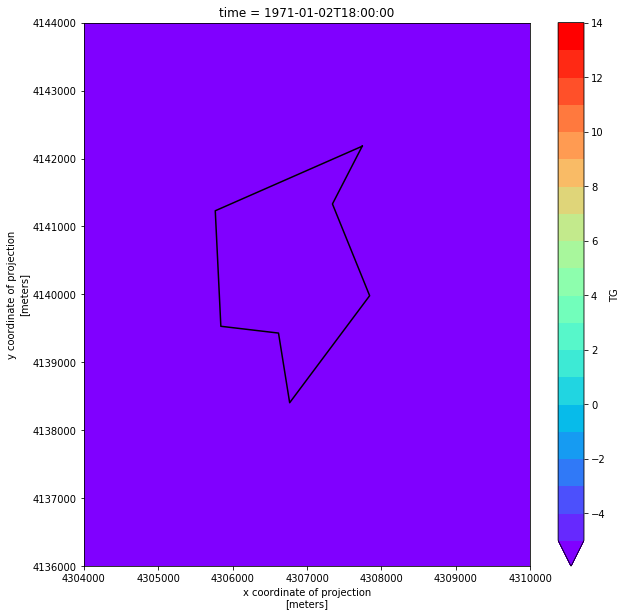

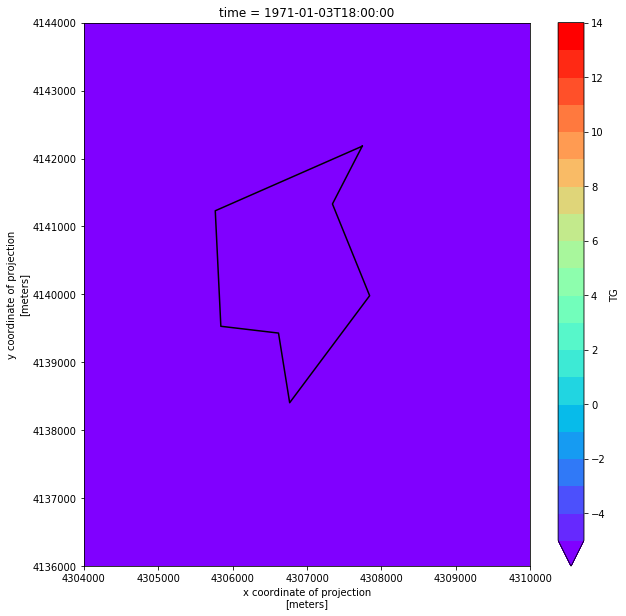

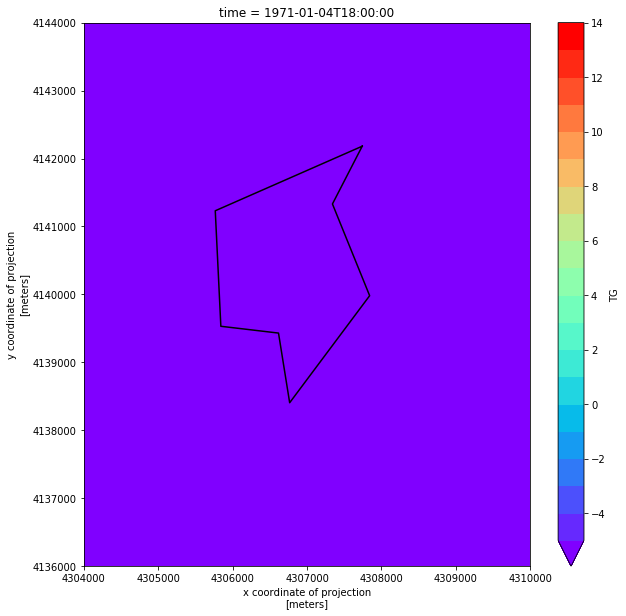

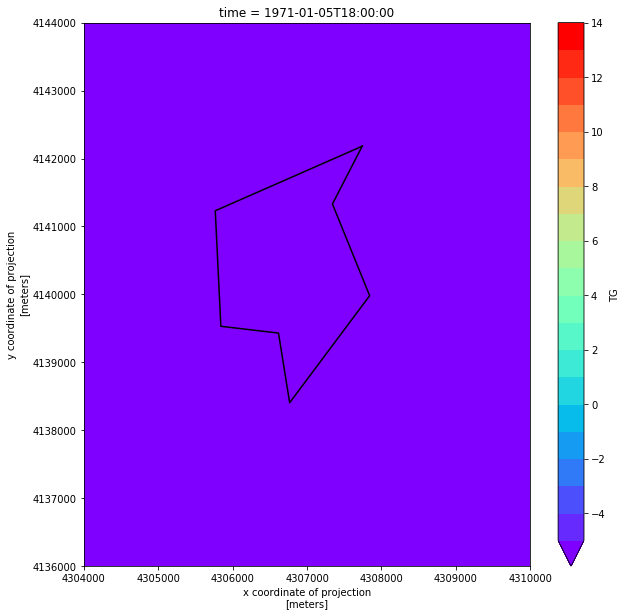

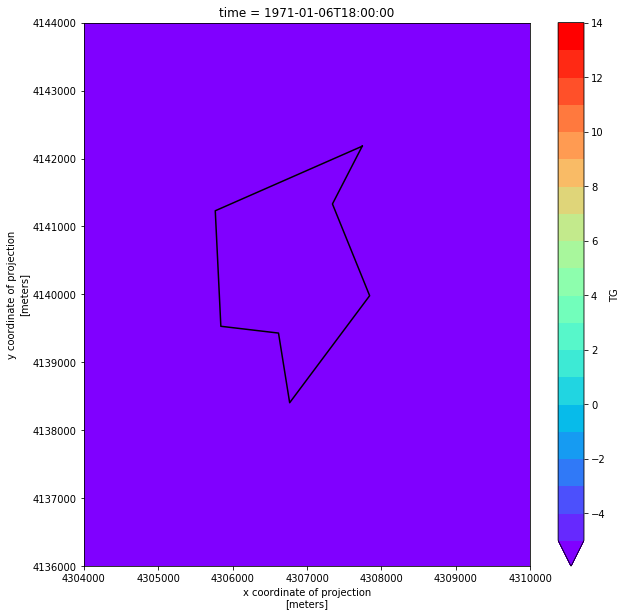

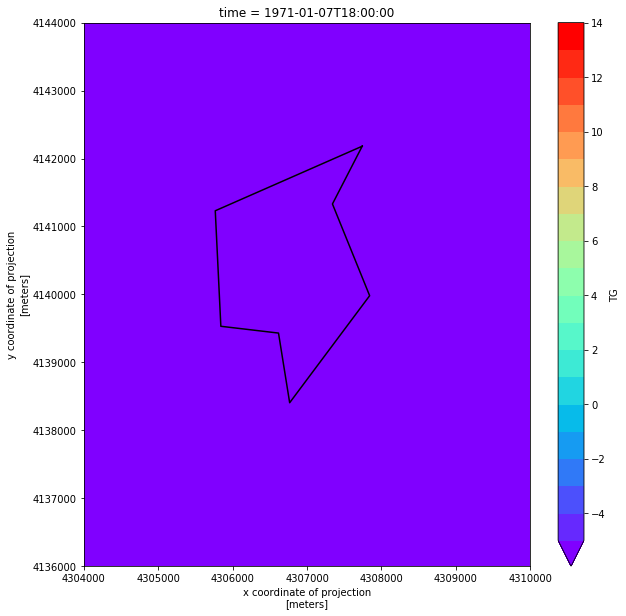

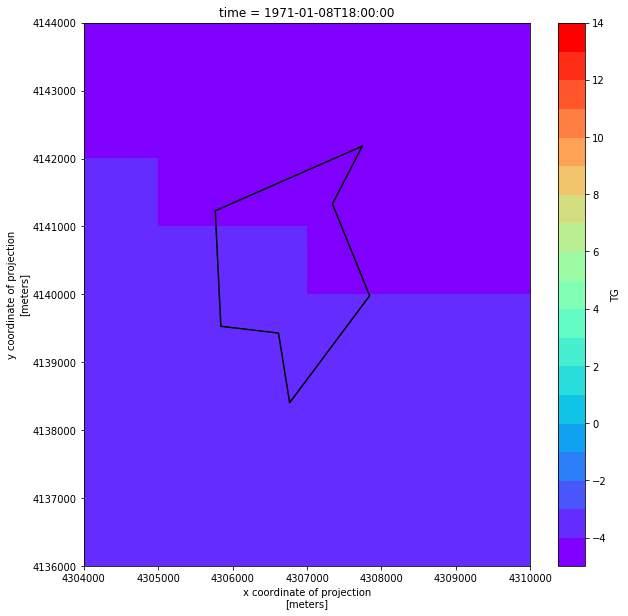

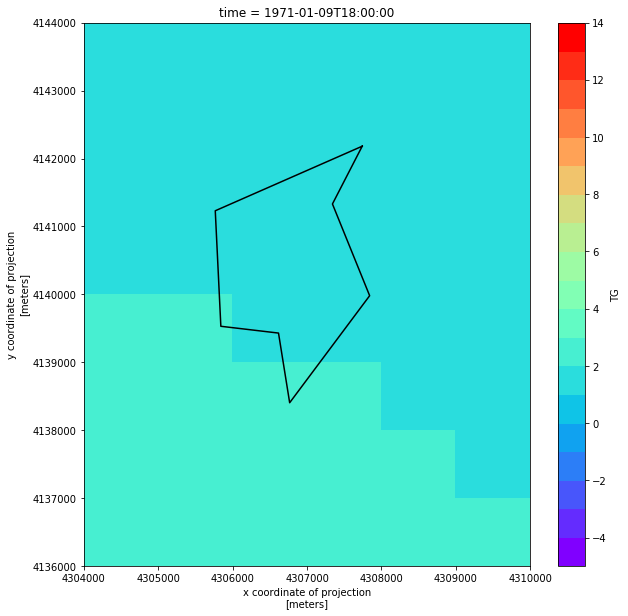

In [8]:
rng = [float(x) for x in range(-5,15)]
for i in range(10):
    air2d = air.isel(time=i)
    plt.figure(figsize=(10,10))
    air2d.plot(levels=rng,cmap=plt.cm.rainbow)
    plt.plot(x,y,'k-')

del air

In [9]:
makeVideo = False

def make_figure():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.epsg(3035))
    # generate a basemap with country borders, oceans and coastlines
    #ax.add_feature(cfeat.LAND)
    #ax.add_feature(cfeat.OCEAN)
    #ax.add_feature(cfeat.COASTLINE)
    #ax.add_feature(cfeat.BORDERS, linestyle='dotted')
    #ax.add_feature(cfeat.RIVERS)
    ax.add_geometries([basin,],crs=ccrs.epsg(3035),edgecolor='black', facecolor='none')
    ax.set_extent((4358465.77233919, 4386543.27233919, 4024442.10566967, 4087444.60566967), crs=ccrs.epsg(3035))
    return fig, ax

def draw(frame, add_colorbar,nc_data,variable):
    grid = variable[frame]
    contour = grid.plot(ax=ax, transform=ccrs.epsg(3035),
                        add_colorbar=add_colorbar, vmin=min_value, vmax=max_value, cmap=cmap)
    title = u"%s — %s" % (variable.long_name, str(nc_data.time[frame].values)[:19])
    ax.set_title(title)
    return contour


def init(nc_data,variable):
    return draw(0, True,nc_data,variable)


def animate(frame,nc_data,variable):
    if((frame % 100)==False):
        print(frame)
    return draw(frame, False,nc_data, variable)


if makeVideo:
    fig, ax = make_figure()


    nc_data = xr.open_dataset(temperatureFile.format(stationName))
    frames = 366
    min_value = -5.  # Lowest value
    max_value = 20.  # Highest value
    cmap='jet'

    videoFile='temp_{}.mp4'.format(stationName)
    ncFile=nc_data
    nc_data.TG.values -= 273.15
    animate_temp = partial(animate,nc_data=nc_data,variable=nc_data.TG)
    init_temp = partial(init,nc_data=nc_data,variable=nc_data.TG)

    if (not os.path.isfile(videoFile)):
        ani = animation.FuncAnimation(fig, animate_temp, frames, interval=0.01, blit=False,
                                      init_func=init_temp, repeat=False)
        ani.save(videoFile, writer=animation.FFMpegWriter(fps=10))


    plt.close(fig)
    nc_data.close()


    fig, ax = make_figure()
    nc_data = xr.open_dataset(rainFile.format(stationName))
    frames = 366 #air.time.size        # Number of frames
    min_value = 0.  # Lowest value
    max_value = 15.  # Highest value
    cmap=cm.get_cmap('Blues')
    # cmap='Blues_r'

    videoFile='rain_{}.mp4'.format(stationName)
    ncFile=nc_data
    animate_rain = partial(animate,nc_data=nc_data,variable=nc_data.RR)
    init_rain = partial(init,nc_data=nc_data,variable=nc_data.RR)

    if (not os.path.isfile(videoFile)):
        ani = animation.FuncAnimation(fig, animate_rain, frames, interval=0.01, blit=False,
                                      init_func=init_rain, repeat=False)
        ani.save(videoFile, writer=animation.FFMpegWriter(fps=10))

    plt.close(fig)    
    nc_data.close()

In [10]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="./temp.mp4" type="video/mp4">
</video></div>""")

In [11]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="./rain.mp4" type="video/mp4">
</video></div>""")

## Uploading to database to get basin average
### Getting boundaries  and intersection with basin for all raster cells


CPU times: user 55.2 ms, sys: 2.47 ms, total: 57.6 ms
Wall time: 1.36 s


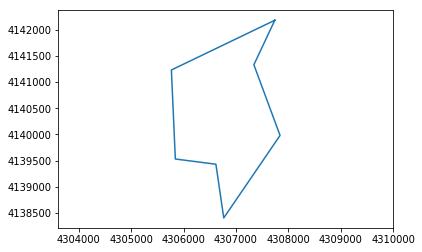

In [12]:
%%time

grid = []
nc_file=temperatureFile.format(stationName)
nc_data = xr.open_dataset(nc_file)
cnt=0;
for i in nc_data.X.values:
    for j in nc_data.Y.values:
        left=i-500
        right=i+500
        bottom=j-500
        top=j+500
        p1 = Point(left,bottom)
        p2 = Point(left,top)
        p3 = Point(right,top)
        p4 = Point(right,bottom)
        pointList = [p1, p2, p3, p4, p1]
        poly = Polygon([[p.x, p.y] for p in pointList])
        poly.sid = cnt;
        grid.append(poly)
        cnt += 1
nc_data.close()    

grid = MultiPolygon(grid) #Trying to make the grid valid
# print(grid.geom_type,grid.is_valid)
# grid = grid.buffer(0)
# print(grid.geom_type,grid.is_valid)

conn = db.connect("dbname={} user={} host={} password={}".format(credentials['database'],
                                                                 credentials['username'],
                                                                 credentials['host'],
                                                                 credentials['password']
                                                                 )
                       )
#And a test query
cursor = conn.cursor()

resultsTable = 'resultsShp'
#Fixing all basin to make the polygons valid
cursor.execute('''UPDATE %(schema)s.%(table)s 
                  SET basin = ST_MakeValid(basin);
               '''
                  ,{"schema": AsIs(basinSchema), "table": AsIs(resultsTable)}
              )
conn.commit()

cursor.execute('''SELECT a.basin FROM %(schema)s.%(table)s AS a
                  WHERE a.station_name ~ '^%(name)s';'''
                  ,{'schema' :  AsIs(basinSchema),
                    'table' :   AsIs(resultsTable),
                    'name':     AsIs(stationName)}
              )


conn.commit()
basin = cursor.fetchone()
basin = loads(box[0], hex=True)
basin = cascaded_union(basin)
x,y = basin.exterior.xy
plt.plot(x,y,)
plt.axis('equal')

#Adding the grid as a Multipolygon:
cursor.execute('''DROP TABLE IF EXISTS %(schema)s.%(table)s;
                  CREATE TABLE %(schema)s.%(table)s (sid SERIAL PRIMARY KEY,
                                                     boundary geometry(MULTIPOLYGON,3035) );
               '''
                  , {"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
              )
conn.commit()

cursor.execute('''INSERT INTO %(schema)s.%(table)s(boundary)
                  VALUES ( 
                             ST_SetSRID( %(geom)s::geometry , %(srid)s ) 
                         );
               ''' ,
               {'schema' : AsIs(basinSchema), 
                'table' : AsIs('dataBoundaries'),
                'geom': grid.wkb_hex,  
                'srid': 3035 
               }  
               )


cursor.execute('''DROP INDEX IF EXISTS %(schema)s.data_boundary_gix;
                  CREATE INDEX data_boundary_gix ON %(schema)s.%(table)s USING GIST (boundary)'''
               ,{"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
              )
conn.commit()

cursor.execute('''DROP INDEX IF EXISTS %(schema)s.basins_gix;
                  CREATE INDEX basins_gix ON %(schema)s.%(table)s USING GIST (basin)'''
               ,{"schema": AsIs(basinSchema), "table": AsIs(resultsTable)}
              )
conn.commit()


cursor.execute('''
                DROP TABLE IF EXISTS test_dump;
                CREATE TEMP TABLE test_dump AS
                SELECT (ST_Dump(boundary)).path[1] as sid, (ST_Dump(boundary)).geom as geom
                FROM %(schema)s.%(gridTable)s;

                CREATE INDEX dump_idx ON test_dump USING GIST(geom);

                DROP TABLE IF EXISTS subdivided_geoms;
                CREATE TEMP TABLE subdivided_geoms AS
                SELECT ST_Subdivide(basin,32) AS geom
                FROM %(schema)s.%(basinTable)s
                WHERE station_name ~ '^%(basinName)s';
                --ALTER TABLE subdivided_geoms ADD COLUMN sid SERIAL PRIMARY KEY;

                CREATE INDEX subdivided_idx ON test_dump USING GIST(geom);

                DROP TABLE IF EXISTS areas;
                CREATE TEMP TABLE areas AS
                WITH biglim AS (
                    SELECT a.sid,ST_Area(ST_Intersection(b.geom, a.geom)) AS area FROM  test_dump AS a, subdivided_geoms AS b
                    WHERE ST_Intersects(a.geom,b.geom)
                ) 
                SELECT sid,SUM(area) as area FROM biglim
                GROUP BY sid;
                ''',{
                    'schema'     : AsIs(basinSchema),
                    'gridTable'  : AsIs('dataBoundaries'), 
                    'basinTable' : AsIs(resultsTable),
                    'basinName'  : AsIs(stationName)
    
                    }
              )
conn.commit()

cursor.execute('''
SELECT * FROM areas;
''')
conn.commit()

weights = cursor.fetchall()


# cursor.execute('''DROP TABLE IF EXISTS %(schema)s.%(table)s;
#                   CREATE TABLE %(schema)s.%(table)s (sid SERIAL PRIMARY KEY,
#                                                      boundary geometry(POLYGON,0),
#                                                      prcIntersection DOUBLE PRECISION                                                   
#                                                      );
#                '''
#                   ,{"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
#               )
# conn.commit()
# execute_values(cursor,'''
#                       INSERT INTO basins.dataBoundaries(boundary,prcIntersection) VALUES %s;
#                       ''', boundaries
#               )

# conn.commit()

# cursor.execute('''ALTER TABLE %(schema)s.%(table)s
#                   ALTER COLUMN boundary TYPE geometry(POLYGON, 3035)
#                   USING ST_SetSRID(boundary,3035);'''
#                ,{"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
#               )
# conn.commit()


# cursor.execute('''CREATE INDEX data_boundary_gix ON %(schema)s.%(table)s USING GIST (boundary)'''
#                ,{"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
#               )
# conn.commit()

# cursor.execute('''UPDATE %(schema)s.%(table)s AS a
#                   SET prcIntersection = (ST_Area(ST_Intersection(a.boundary,b.basin)))
#                   FROM basins.resultsShp AS b
#                   WHERE b.sid=1 AND ST_Intersects(a.boundary,b.basin); 
#                   ;'''
#                ,{"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
#               )
# conn.commit()
              
# #Getting results
# cursor.execute('''SELECT a.sid,a.prcIntersection FROM %(schema)s.%(table)s AS a; 
#                '''
#                ,{"schema": AsIs(basinSchema), "table": AsIs("dataBoundaries")}
#               )
# conn.commit()

# weights=cursor.fetchall()
# weights = [(i[0],i[1]) for i in weights]

# print(weights)
    
    
conn.close()

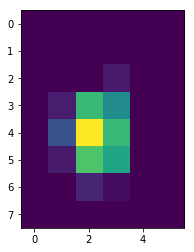

In [13]:
idx = [i[0] for i in weights]
weight = [i[1] for i in weights]

#Getting the in a 2d array
weightArray = np.zeros((dataShape[1:]))
arrayIdx = np.unravel_index(idx,dataShape[2:0:-1])
for i,j,k in zip(arrayIdx[1],arrayIdx[0],weight):
    weightArray[i][j] = k;

plt.imshow(weightArray)


def getWeightedData(filename,variable,save=True):
    nc_data = xr.open_dataset(filename,chunks={'time':1000})
    time = nc_data.time.values
    total_weight = sum(weight)
    data = np.sum(np.sum((nc_data.variables[variable] * weightArray)/total_weight,axis=1),axis=1)
    nc_data.close()
    if save:
        data_df = pd.DataFrame({variable:data},index=time)
        data_df.to_pickle('./{}_{}.pickle'.format(variable,stationName))
        data_df.to_csv('./{}_{}.csv'.format(variable,stationName))
    return data_df

### Applying weights

CPU times: user 369 ms, sys: 105 ms, total: 474 ms
Wall time: 303 ms


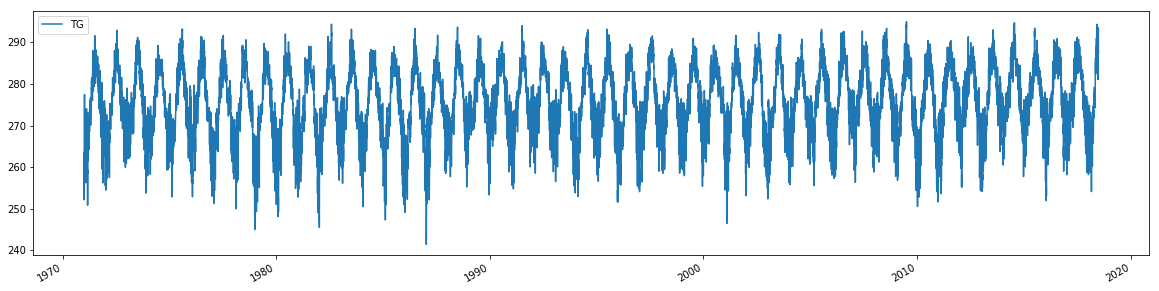

In [14]:
%%time

temperature_df = getWeightedData(temperatureFile.format(stationName),'TG')
temperature_df.plot(figsize=(20,5))

CPU times: user 206 ms, sys: 41.3 ms, total: 247 ms
Wall time: 184 ms


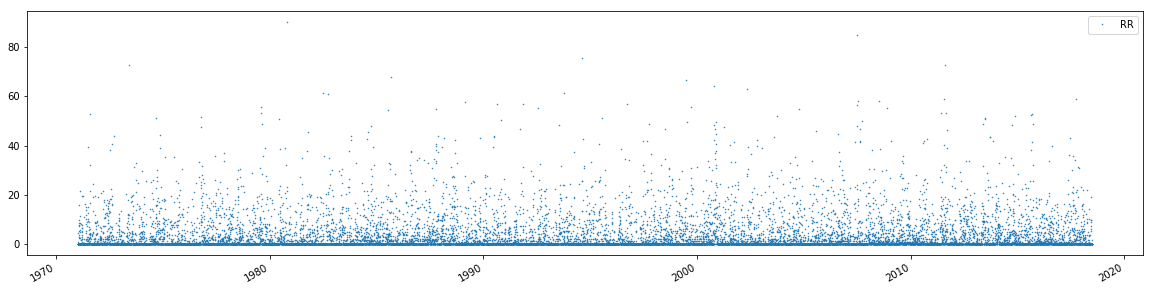

In [15]:
%%time
rain_df = getWeightedData(rainFile.format(stationName),'RR')
rain_df.plot(figsize=(20,5),linestyle='None',marker='.',markersize=1)


CPU times: user 220 ms, sys: 28 ms, total: 248 ms
Wall time: 187 ms


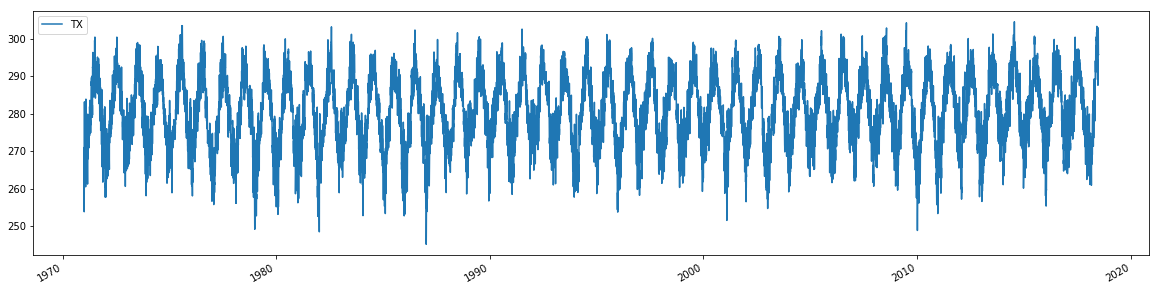

In [16]:
%%time
max_temp_df = getWeightedData(maxTempFile.format(stationName),'TX')
max_temp_df.plot(figsize=(20,5))


CPU times: user 190 ms, sys: 13.2 ms, total: 203 ms
Wall time: 170 ms


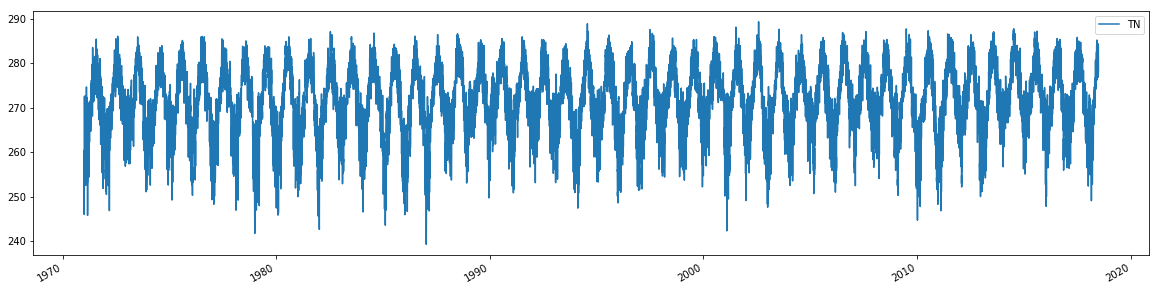

In [17]:
%%time
min_temp_df = getWeightedData(minTempFile.format(stationName),'TN')
min_temp_df.plot(figsize=(20,5))

(735599.0, 735963.0)

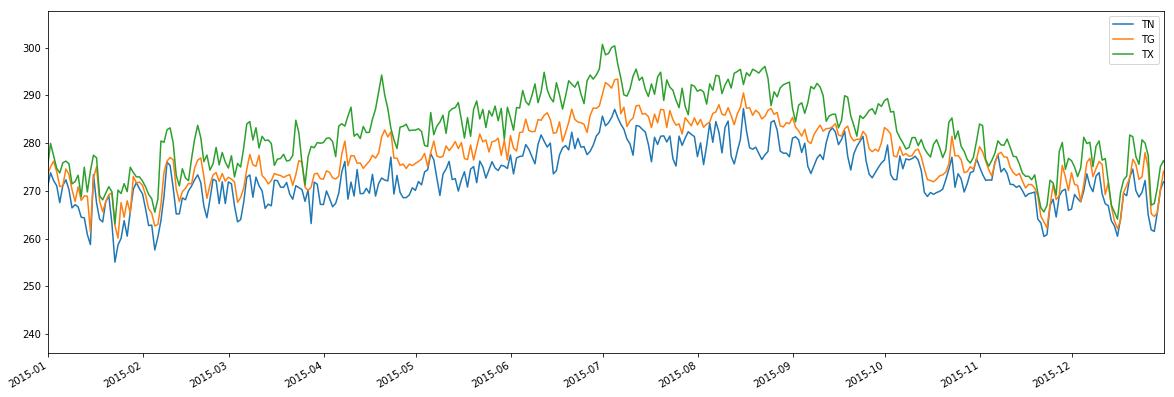

In [18]:
ax = min_temp_df.plot()
temperature_df.plot(ax=ax)
max_temp_df.plot(ax=ax,figsize=(20,7))
ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-12-31'))
